In [7]:
!pip install kaggle opencv-python scikit-learn matplotlib tqdm scikit-image

In [11]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle (4).json to kaggle (4).json


{'kaggle (4).json': b'{"username":"pranjalisakure","key":"9040e03670d49c180ef106503b6da271"}'}

In [13]:
!mkdir -p ~/.kaggle
!mv "kaggle (4).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:08<00:00, 55.2MB/s]
100% 812M/812M [00:08<00:00, 103MB/s] 


In [16]:
!unzip -q dogs-vs-cats.zip -d data
!unzip -q data/train.zip -d data/train_raw

In [26]:
import os, shutil, re

# Paths
src = "data/train_raw"
dst_cat = "data/train/cat"
dst_dog = "data/train/dog"

# Make folders if they don't exist
os.makedirs(dst_cat, exist_ok=True)
os.makedirs(dst_dog, exist_ok=True)

# Check if folders already have images
cat_count = len(os.listdir(dst_cat))
dog_count = len(os.listdir(dst_dog))

if cat_count == 0 or dog_count == 0:
    print("Folders empty, moving images from train_raw...")
    for fn in os.listdir(src):
        if re.match(r"cat\.\d+\.jpg", fn):
            shutil.move(os.path.join(src, fn), os.path.join(dst_cat, fn))
        elif re.match(r"dog\.\d+\.jpg", fn):
            shutil.move(os.path.join(src, fn), os.path.join(dst_dog, fn))
else:
    print("Folders already contain images.")

print("Cats:", len(os.listdir(dst_cat)))
print("Dogs:", len(os.listdir(dst_dog)))

Folders already contain images.
Cats: 12500
Dogs: 12500


In [27]:
print("Cats:", len(os.listdir("data/train/cat")))
print("Dogs:", len(os.listdir("data/train/dog")))

Cats: 12500
Dogs: 12500


In [29]:
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm

def load_hog(data_dir, limit=1000):  # limit keeps training fast
    X, y = [], []
    for label_name, label in [("cat", 0), ("dog", 1)]:
        folder = os.path.join(data_dir, label_name)
        files = os.listdir(folder)[:limit]
        for fn in tqdm(files, desc=f"HOG {label_name}"):
            img = cv2.imread(os.path.join(folder, fn), cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            img = cv2.resize(img, (128,128))
            features = hog(img, orientations=9, pixels_per_cell=(8,8),
                           cells_per_block=(2,2), block_norm='L2-Hys')
            X.append(features)
            y.append(label)
    return np.array(X), np.array(y)

X, y = load_hog("data/train", limit=1000)
print("Loaded samples:", len(X))

HOG dog: 100%|██████████| 1000/1000 [00:09<00:00, 108.81it/s]


Loaded samples: 2000


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale', probability=True))
svm.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, svm.predict(X_test)))

Accuracy: 0.7225


In [38]:
def analyze_image(img_path, svm_model):
    import cv2
    import matplotlib.pyplot as plt
    from skimage.feature import hog

    # Load image
    img_color = cv2.imread(img_path)
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_gray = cv2.resize(img_gray, (128,128))

    # HOG features + visualization
    hog_features, hog_image = hog(
        img_gray, orientations=9, pixels_per_cell=(8,8),
        cells_per_block=(2,2), block_norm='L2-Hys',
        visualize=True
    )

    # Predict
    features = hog_features.reshape(1, -1)
    prediction = svm_model.predict(features)[0]
    confidence = svm_model.predict_proba(features)[0][prediction]
    label = "Dog" if prediction == 1 else "Cat"
    score = round(confidence * 100, 2)

    # Show results
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(img_color); plt.title("Human View"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(hog_image, cmap='gray'); plt.title("AI View (HOG Features)"); plt.axis("off")
    plt.suptitle(f"Prediction: {label} | Confidence Score: {score}%", fontsize=14)
    plt.tight_layout()
    plt.show()

Saving dog.jpg to dog.jpg


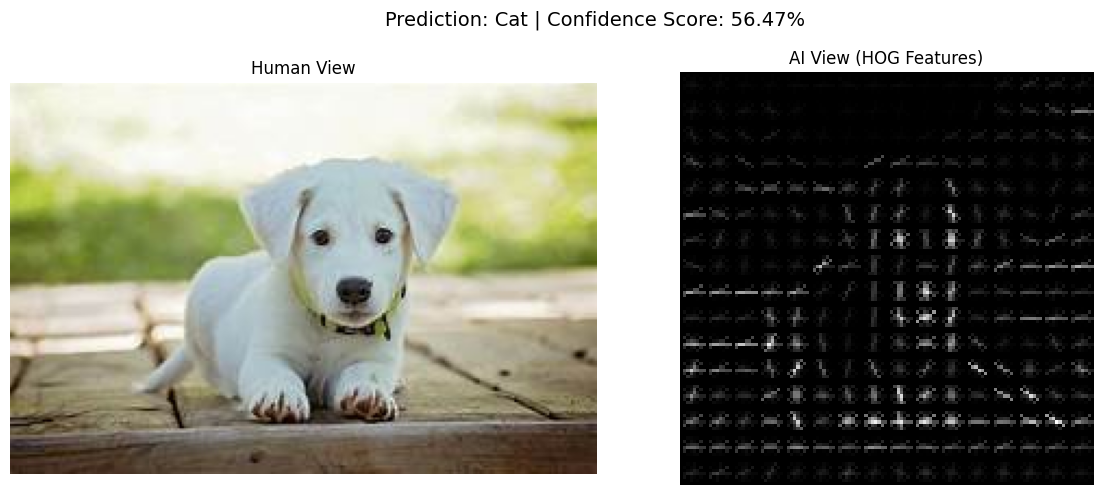

In [40]:
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

analyze_image(img_path, svm)